# Classification Animals-10 using MLP

Task: load the Animals-10, write a MLP model to perform classification over most frequent face classes, test the network and plot the results for each class.

<!-- ![Animals-10](https://storage.googleapis.com/kaggle-datasets-images/59760/115796/95649e825d9344084af2a24012c4d072/dataset-cover.jpg?t=2018-10-05-08-07-40) -->

### Importing libraries

In [1]:
# We need to first install PyTorch Lightning, since it's not included in Python
%pip install pytorch-lightning torchvision


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [22]:
import os

# Matplotlib for plotting, numpy for math operations, pandas for data manipulation
from matplotlib import pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import pandas as pd

# PyTorch Lightning ⚡ to define our neural network
import torch
import torch.nn as nn
from torch.nn import functional as F
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.tuner import Tuner

# Dataloader and torchvision to define our input dataset
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import make_grid

# Torchmetrics to monitor metrics (classification accuracy)
from torchmetrics.functional.classification.accuracy import accuracy
%matplotlib inline
%config InlineBackend.figure_format = "svg"

In [8]:
# Seed all random number generators
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(SEED)
if torch.backends.cudnn.enabled:
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

### Hyperparameter definition


*   **Input width** - width of the input image
*   **Input height** - height of the input image
*   **Input channels** - number of channels of the input image
*   **Train percentage** - percentage of the dataset used for training
*   **Validation percentage** - percentage of the dataset used for validation
*   **Test percentage** - percentage of the dataset used for testing
*   **Learning rate** - Learning rate used by the Adam optimizer
*   **Batch size** - how many samples does the network "see" at every iteration (usually, the bigger the better)
*   **Epochs** - how many times the network sees the entire dataset
*   **Source folder** - folder where the dataset is stored

In [9]:
input_width = 128
input_height = 128
input_channels = 3

train_percentage = 0.7
val_percentage = 0.15
test_percentage = 0.15

batch_size = 64
epochs = 10

source_folder = 'animals10/raw-img' # Substitute with 'animals10-tiny/raw-img' for the small dataset (1K images)

### Importing dataset
Link full dataset: https://www.kaggle.com/datasets/alessiocorrado99/animals10

Link tiny version: https://drive.google.com/file/d/1mJWlU-jHWYZPonFHF5Kmdhhb6OfJmnD5/view?usp=sharing

In [10]:
# Prepare the images for the model
manual_transform = transforms.Compose([
  transforms.Resize((input_width, input_height)), # Resize the image to 128x128
  transforms.ToTensor(), # Convert the image to a PyTorch Tensor
  transforms.Normalize(mean=[0.5126, 0.4952, 0.4027], std=[0.2649, 0.2580, 0.2753]), # Normalize the image
])

dataset = ImageFolder(root=source_folder, transform=manual_transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46753496..1.5848166].


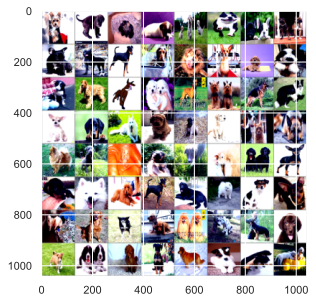

In [23]:
# Function to show an image
def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# Get a batch of training data
dataiter = iter(loader)
images, labels = next(dataiter)

# Show images
imshow(make_grid(images))

### DataModule definition

In [13]:
class MyCustomDataModule(pl.LightningDataModule):
  def __init__(self, data_dir: str = "./"):
    super().__init__()

  def prepare_data(self):
    self.dataset = dataset

  def setup(self, stage = None):
    dataset_size = len(dataset)
    train_size = int(train_percentage * dataset_size)
    val_size = int(val_percentage * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Split the dataset into train, validation and test sets
    self.dataset_train, self.dataset_val, self.dataset_test = random_split(self.dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(SEED))

  def train_dataloader(self):
    return DataLoader(self.dataset_train, batch_size=batch_size)

  def val_dataloader(self):
    return DataLoader(self.dataset_val, batch_size=batch_size)

  def test_dataloader(self):
    return DataLoader(self.dataset_test, batch_size=batch_size)

### Neural network definition
The \_\_init\_\_ and forward methods define the neural network architecture. The training, validation and test functions compute the loss and accuracy of the model on the respective datasets.


In [14]:
class MyCustomModel(LightningModule):
  def __init__(self):
    super().__init__()

    self.ground_truth = []
    self.predictions = []

    # Define the layers of the model
    self.fc1 = nn.Linear(128*128*3, 980)
    self.fc2 = nn.Linear(980, 123)
    self.fc3 = nn.Linear(123, 10)
    
    self.dropout = nn.Dropout(p= 0.25)

  def forward(self, x):
    # Define the neural network structure
    x = x.view(x.size(0), -1) # Flatten the input tensor
    x = self.dropout(F.relu(self.fc1(x))) # First fully connected layer
    x = self.dropout(F.relu(self.fc2(x))) # Second fully connected layer
    x = F.log_softmax(self.fc3(x), dim=1) # Output layer with log softmax activation function
    return x

  def training_step(self, batch, batch_nb):
    input, target = batch
    input = self(input)
    loss = F.cross_entropy(input, target)

    preds = torch.argmax(input, dim=1)
    acc = accuracy(preds, target, task='multiclass',num_classes=len(target))

    self.log("train_loss", loss, prog_bar=True, on_epoch=True, on_step=False, logger=True)
    self.log("train_acc", acc, prog_bar=True, on_epoch=True, on_step=False, logger=True)

    return loss

  def validation_step(self, batch, batch_nb):
    input, target = batch
    input = self(input)
    loss = F.cross_entropy(input, target)

    preds = torch.argmax(input, dim=1)
    acc = accuracy(preds, target, task='multiclass', num_classes=len(target))

    self.log("val_loss", loss, prog_bar=True, on_epoch=True, on_step=False, logger=True)
    self.log("val_acc", acc, prog_bar=True, on_epoch=True, on_step=False, logger=True)

    return loss

  def test_step(self, batch, batch_nb):
    input, target = batch
    input = self(input)
    loss = F.cross_entropy(input, target)

    preds = torch.argmax(input, dim=1)
    acc = accuracy(preds, target, task='multiclass', num_classes=len(target))

    self.ground_truth.append(target.data)     # Save ground truth
    self.predictions.append(preds.data)       # Save predictions

    self.log("test_loss", loss, prog_bar=True, on_epoch=True, on_step=False, logger=True)
    self.log("test_acc", acc, prog_bar=True, on_epoch=True, on_step=False, logger=True)

    return loss

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=0.0001)

### Training

In [15]:
# Init our model
model = MyCustomModel()

# Init DataModule
datamodule = MyCustomDataModule()

# Initialize a trainer
trainer = Trainer(
  max_epochs=10
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [16]:
import gc
%set_env PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

# Train the model
trainer.fit(model, datamodule)
gc.collect()

env: PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0



  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | fc1     | Linear  | 48.2 M | train
1 | fc2     | Linear  | 120 K  | train
2 | fc3     | Linear  | 1.2 K  | train
3 | dropout | Dropout | 0      | train
--------------------------------------------
48.3 M    Trainable params
0         Non-trainable params
48.3 M    Total params
193.167   Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 287/287 [01:13<00:00,  3.90it/s, v_num=195, val_loss=1.760, val_acc=0.420, train_loss=1.300, train_acc=0.546]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 287/287 [01:14<00:00,  3.85it/s, v_num=195, val_loss=1.760, val_acc=0.420, train_loss=1.300, train_acc=0.546]


145

### Training evaluation

Latest version: 195


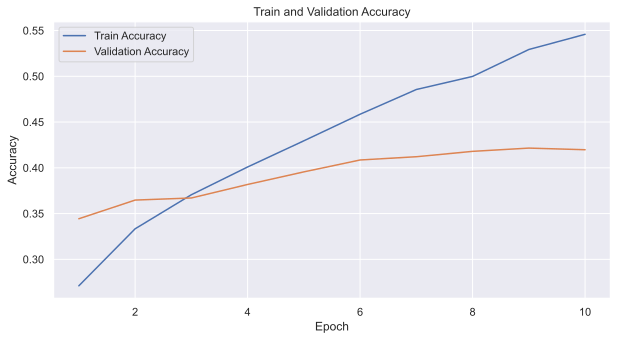

In [24]:
# Load the logs
# Load the latest version of the logs
log_dir = 'lightning_logs'
latest_version = max([int(d.split('_')[-1]) for d in os.listdir(log_dir) if d.startswith('version_')])
metrics = pd.read_csv(f'{log_dir}/version_{latest_version}/metrics.csv')

print(f'Latest version: {latest_version}')

# Extract the relevant data
train_acc = metrics['train_acc'].dropna().values
val_acc = metrics['val_acc'].dropna().values
epochs = range(1, len(train_acc) + 1)

# Plot train and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

### Model testing

In [18]:
trainer.test(model, datamodule=datamodule)

/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 62/62 [00:09<00:00,  6.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.41700610518455505
        test_loss           1.7651474475860596
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.7651474475860596, 'test_acc': 0.41700610518455505}]

### Results

In [19]:
print("Ground truth length: ", len(model.ground_truth))
print("Predictions length: ", len(model.predictions))

print("Ground truth sample: ", model.ground_truth)
print("Predictions sample: ", model.predictions)

Ground truth length:  62
Predictions length:  62
Ground truth sample:  [tensor([4, 9, 8, 8, 8, 3, 8, 7, 4, 5, 0, 5, 9, 1, 0, 0, 5, 2, 0, 0, 7, 2, 4, 1,
        5, 0, 8, 8, 0, 3, 4, 0, 0, 7, 8, 8, 6, 8, 4, 0, 9, 7, 8, 5, 8, 6, 0, 8,
        3, 8, 3, 2, 4, 2, 7, 6, 1, 8, 2, 1, 8, 2, 1, 8], device='mps:0'), tensor([6, 5, 7, 0, 5, 4, 1, 7, 4, 8, 0, 4, 9, 7, 3, 8, 3, 4, 4, 4, 1, 9, 4, 3,
        6, 0, 0, 1, 2, 4, 0, 7, 4, 4, 6, 0, 8, 3, 4, 8, 7, 4, 6, 1, 1, 3, 9, 8,
        1, 0, 4, 7, 0, 0, 0, 8, 4, 9, 0, 1, 3, 4, 4, 1], device='mps:0'), tensor([3, 0, 1, 3, 1, 8, 0, 5, 0, 9, 1, 0, 4, 9, 1, 9, 5, 4, 3, 0, 0, 7, 4, 0,
        6, 7, 4, 7, 3, 9, 6, 3, 8, 6, 4, 0, 7, 3, 9, 3, 1, 5, 5, 9, 8, 5, 4, 3,
        4, 8, 9, 6, 0, 9, 9, 8, 3, 0, 5, 4, 8, 6, 4, 9], device='mps:0'), tensor([4, 0, 0, 4, 8, 7, 1, 8, 0, 8, 3, 7, 4, 0, 7, 0, 8, 9, 5, 0, 9, 0, 0, 8,
        2, 9, 3, 7, 0, 4, 8, 5, 4, 1, 6, 8, 0, 9, 2, 0, 9, 0, 0, 0, 0, 3, 7, 7,
        0, 4, 5, 5, 0, 9, 8, 4, 0, 3, 7, 0, 1, 3, 0, 8], device='m

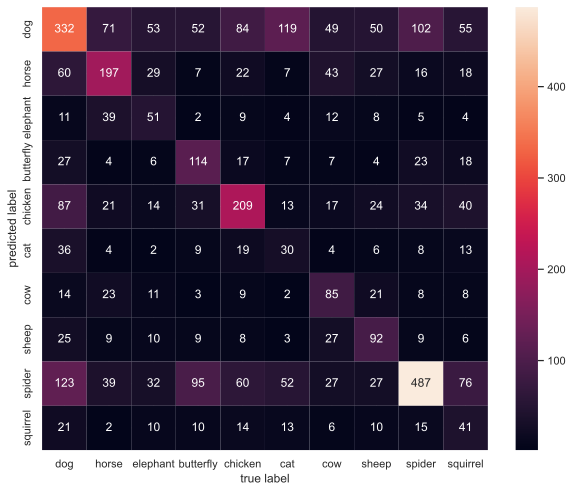

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming class_labels contains the animal names
animal_names = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']

# Flatten the ground truth and predictions
ground_truth_flat = torch.cat(model.ground_truth).cpu().numpy()
predictions_flat = torch.cat(model.predictions).cpu().numpy()

# Compute the confusion matrix
cm = confusion_matrix(predictions_flat, ground_truth_flat)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=animal_names, yticklabels=animal_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()